# <p align="center">OSLO</p>


![Imagen local](Oslo_portada.jpg)

#### Fuentes: 

Foto portada: https://fiordosnoruegos.org/oslo/

Foto bandera indice: https://es.wikipedia.org/wiki/Bandera_de_Noruega

#### Limpieza del dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly_express as px

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [2]:
print(os.listdir("input"))

['calendar.csv', 'calendar.csv.gz', 'listings.csv', 'listings.csv.gz', 'listings_details.csv', 'neighbourhoods.csv', 'neighbourhoods.geojson', 'reviews.csv', 'reviews.csv2.gz', 'reviews_details.csv']


In [3]:
listings = pd.read_csv("input/listings.csv", index_col= "id")
listings_details = pd.read_csv("input/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("input/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("input/reviews_details.csv", parse_dates=['date'])

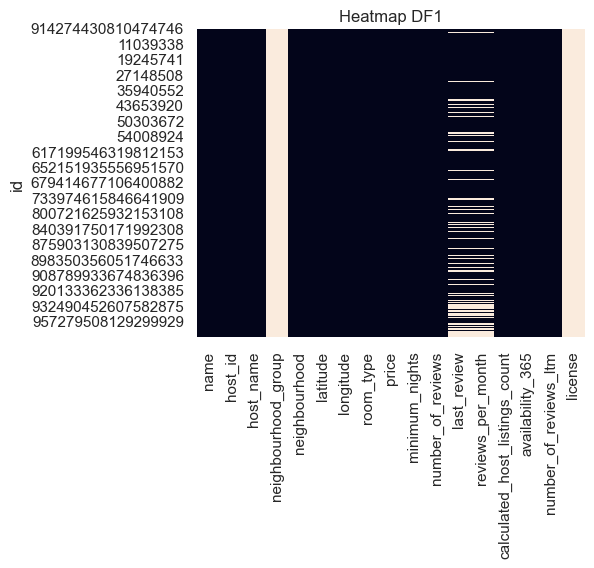

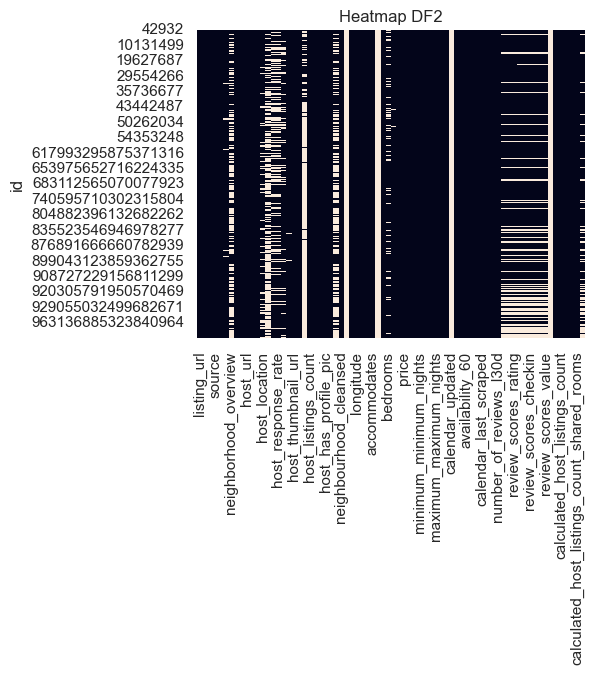

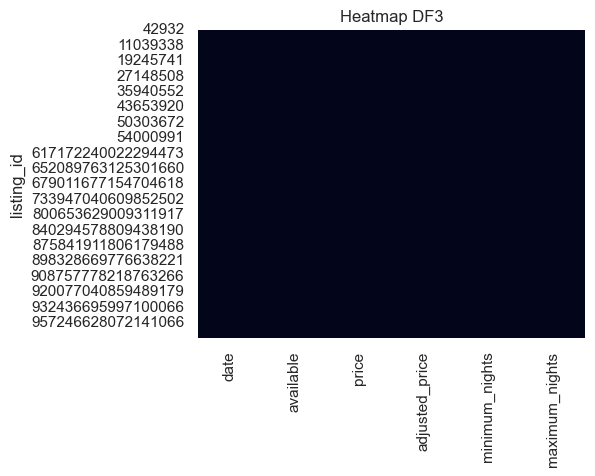

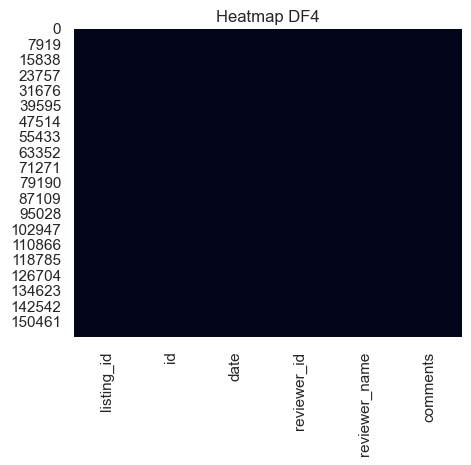

In [4]:
dfs = [listings, listings_details, calendar, reviews_details] # Agrupamos en un solo df
for i, df in enumerate(dfs):
    plt.figure(figsize=(5, 4))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title(f'Heatmap DF{i+1}')
    plt.show()

In [5]:
listings.isnull().sum()/len(listings)*100

name                                0.000000
host_id                             0.000000
host_name                           0.000000
neighbourhood_group               100.000000
neighbourhood                       0.000000
latitude                            0.000000
longitude                           0.000000
room_type                           0.000000
price                               0.000000
minimum_nights                      0.000000
number_of_reviews                   0.000000
last_review                        19.240183
reviews_per_month                  19.240183
calculated_host_listings_count      0.000000
availability_365                    0.000000
number_of_reviews_ltm               0.000000
license                           100.000000
dtype: float64

In [6]:
listings_details.isnull().sum()/len(listings_details)*100

listing_url                                      0.000000
scrape_id                                        0.000000
last_scraped                                     0.000000
source                                           0.000000
name                                             0.000000
                                                  ...    
calculated_host_listings_count                   0.000000
calculated_host_listings_count_entire_homes      0.000000
calculated_host_listings_count_private_rooms     0.000000
calculated_host_listings_count_shared_rooms      0.000000
reviews_per_month                               19.240183
Length: 74, dtype: float64

In [7]:
calendar.isnull().sum()/len(calendar)*100

date              0.0
available         0.0
price             0.0
adjusted_price    0.0
minimum_nights    0.0
maximum_nights    0.0
dtype: float64

In [8]:
reviews_details.isnull().sum()/len(reviews_details)*100

listing_id       0.00000
id               0.00000
date             0.00000
reviewer_id      0.00000
reviewer_name    0.00000
comments         0.00442
dtype: float64

In [9]:
def remove_nulls(df:pd.DataFrame, threshold:float= 0.3)->pd.DataFrame:
    cols_to_Drop = df.columns[df.isnull().mean() > threshold]
    df = df.drop(columns=cols_to_Drop)
    return df

In [10]:
listings = remove_nulls(listings)
listings_details = remove_nulls(listings_details)
calendar = remove_nulls(calendar)
reviews_details = remove_nulls(reviews_details)

In [11]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')

In [12]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_response_time", "host_response_rate"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9397 entries, 914274430810474746 to 986288088626056805
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            9397 non-null   object 
 1   host_id                         9397 non-null   int64  
 2   host_name                       9397 non-null   object 
 3   neighbourhood                   9397 non-null   object 
 4   latitude                        9397 non-null   float64
 5   longitude                       9397 non-null   float64
 6   room_type                       9397 non-null   object 
 7   price                           9397 non-null   int64  
 8   minimum_nights                  9397 non-null   int64  
 9   number_of_reviews               9397 non-null   int64  
 10  last_review                     7589 non-null   object 
 11  reviews_per_month               7589 non-null   float64
 12  calculat

In [13]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_response_time,host_response_rate
id,,,,,,,,,,,,,,,,,,,,,
914274430810474746,Rental unit in Bydel Alna · ★5.0 · 2 bedrooms ...,34923127,Leif,Alna,59.936718,10.925452,Entire home/apt,750,3,4,...,4.50,4.75,5.00,4.75,5.00,31,https://www.airbnb.com/rooms/914274430810474746,f,within an hour,100.0
42932,Rental unit in Oslo · ★4.90 · 2 bedrooms · 3 b...,187463,Cecilie,Frogner,59.912010,10.724550,Entire home/apt,3400,3,56,...,4.96,4.96,4.96,4.94,4.90,1125,https://www.airbnb.com/rooms/42932,t,within an hour,100.0
69964,Rental unit in Oslo · ★4.78 · 1 bedroom · 1 be...,175633,Kristin,Sagene,59.940590,10.773970,Entire home/apt,1098,28,9,...,4.50,4.75,5.00,5.00,4.78,600,https://www.airbnb.com/rooms/69964,f,NaN,NaN
71725,Rental unit in Oslo · ★4.74 · 1 bedroom · 2 be...,368229,Reidun,Gamle Oslo,59.907950,10.779870,Private room,573,14,55,...,4.69,4.67,4.94,4.98,4.74,730,https://www.airbnb.com/rooms/71725,t,NaN,NaN
85902,Condo in Oslo · ★4.77 · 2 bedrooms · 3 beds · ...,250159,Melissa,Gamle Oslo,59.910740,10.772320,Entire home/apt,1300,3,77,...,4.47,4.77,4.83,4.72,4.77,21,https://www.airbnb.com/rooms/85902,t,within an hour,100.0


In [14]:
listings.isnull().sum()

name                                 0
host_id                              0
host_name                            0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1808
reviews_per_month                 1808
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
property_type                        0
accommodates                         0
first_review                      1808
review_scores_value               1831
review_scores_cleanliness         1830
review_scores_location            1830
review_scores_accuracy            1830
review_scores_communication       1830
review_scores_checkin             1830
review_scores_rating              1808
maximum_nights           

In [15]:
def replace_missing_data(df):
# Vemos qué columnas tienen valores nulos
    mis_cols = list(df.isnull().sum(axis=0)[df.isnull().sum(axis=0)>0].index)

# Iteramos sobre ellas
    for col in mis_cols:
        # Si la variable es discreta,...
        if df[col].dtype in ['object']:
            mode_col = df[col].mode().values[0]
            df[col] = df[col].fillna(mode_col)
        # Si son números enteros
        elif df[col].dtype in ['int']:
            df[col] = df[col].fillna(df[col].median())
        # Si son números reales
        elif df[col].dtype in ['float']:
            df[col] = df[col].fillna(df[col].mean())
    # Devolvemos el DataFrame
    return df

In [16]:
listings = replace_missing_data(listings)

In [17]:
listings.isnull().sum()

name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
property_type                     0
accommodates                      0
first_review                      0
review_scores_value               0
review_scores_cleanliness         0
review_scores_location            0
review_scores_accuracy            0
review_scores_communication       0
review_scores_checkin             0
review_scores_rating              0
maximum_nights                    0
listing_url                       0
host_is_superhost           

# ÍNDICE ![Imagen bandera](Bandera.png)

1. Introducción
2. Vecindario    
   2.1 Mapa de barrios    
   2.2 Mapa de localizaciones   
3. Tipos de habitaciones y propiedades   
   3.1 Tipos de habitaciones   
   3.2 Tipos de propiedades   
   3.3 Número de alojados   
4. Precio medio por vecindario   
5. Seguridad en los vecindarios   
6. Análisis de las reseñas (limpieza, precisión, valor, comunicación, ubicación, etc)   
7. Superhost   
   7.1 Número y porcentaje de anuncios con superhost   
   7.2 Tiempo de respuesta   
   7.3 Host con más alojamientos    
8. Disponibilidad en el tiempo   
   8.1 Publicaciones disponibles por fecha   
   8.2 Precio medio por día   
9. Minería de texto   
10. Conclusiones   

## 1. Introducción

Oslo, la capital de Noruega, es una ciudad que combina la modernidad con una rica herencia histórica y una impresionante belleza natural. Situada en la costa sur del país, Oslo es conocida por su alto nivel de vida, su compromiso con la sostenibilidad y su vibrante escena cultural. A continuación, exploraremos algunas de las características positivas y negativas de la ciudad desde la perspectiva de los datos de Airbnb.

**Áspectos positivos:**

1. **Naturaleza espectacular:** Oslo se encuentra en un entorno natural impresionante, con el fiordo de Oslo y numerosos parques y bosques. Esto ofrece oportunidades para actividades al aire libre, como senderismo, ciclismo y navegación.

2. **Calidad de vida:** Oslo se clasifica constantemente como una de las ciudades con mejor calidad de vida en el mundo debido a su atención médica de calidad, educación, seguridad y servicios públicos.

3. **Cultura y patrimonio:** La ciudad alberga una serie de museos, galerías de arte y sitios históricos, como el Museo Munch, el Museo de Barcos Vikingos y el Ayuntamiento de Oslo. Además, es famosa por su arquitectura moderna y diseño.

4. **Gastronomía:** Oslo ofrece una escena culinaria diversa con una creciente cantidad de restaurantes de alta calidad que sirven platos noruegos e internacionales.

**Áspectos a tener en cuenta:**

1. **Costo de vida elevado:** Oslo es una de las ciudades más caras del mundo. Los precios de alojamiento, comida y entretenimiento son significativamente altos, lo que puede hacer que la estadía sea costosa.

2. **Clima frío:** El clima en Oslo es frío durante gran parte del año, con inviernos largos y fríos. La falta de luz solar durante el invierno puede afectar el estado de ánimo y la energía.

3. **Tráfico y transporte público:** El tráfico puede ser congestionado en horas pico, y el sistema de transporte público, aunque eficiente, puede ser costoso para los visitantes.

4. **Temporada alta de turismo:** Durante la temporada alta de turismo, Oslo puede estar abarrotada y los precios de alojamiento pueden dispararse, lo que dificulta encontrar alojamiento asequible.

En general, Oslo es una ciudad hermosa y vibrante con muchas cualidades positivas, pero también enfrenta desafíos como el alto costo de vida y el clima frío. Los datos de Airbnb pueden proporcionar información valiosa sobre las opciones de alojamiento y ayudar a los visitantes a tomar decisiones informadas al planificar su viaje a esta encantadora ciudad noruega.

## 2. VECINDARIO

La provincia de Oslo tiene una superficie total de **457 km²**. Su área metropolitana se extiende a los alrededores de la provincia de **Akershus** (hoy integrada en la provincia de Viken) y tiene una población de 1.546.706 habitantes. La superficie total metropolitana, comprendida por Oslo es de **144 km²**, de los cuales **115 km² son urbanos y 7 km² son rurales**. El resto de la superficie corresponde a entornos rurales y marítimos.

### 2.1 Mapa de barrios

In [18]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
fig = px.bar(feq, orientation="h", title="Mapa de barrios", template="plotly_dark")
fig.data[0].marker.color = ['blue'] * 12 + ['red'] * (len(feq) - 12)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')
fig.update_layout(showlegend=False)
fig.update_layout(title_font_size=30)


fig.show()

### 2.2 Mapa de localizaciones

In [19]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[59.913333, 10.738889], zoom_start=11)
FastMarkerCluster(data=locations).add_to(map1)
map1

## 3. TIPO DE HABITACIONES Y PROPIEDADES DISPONIBLES

En Oslo, según la normativa que entro en vigor el 1 de enero de 2020, no existe ninguna restricción en cuanto al número de días en los que se puede alquilar este tipo de habitaciones y propiedades como suele pasar en otras ciudades o paises. Como podemos ver a continuación en los siguientes gráficos, lo más demandado son las casa/apartamentos completos.

### 3.1 Tipos de habitaciones

In [20]:
fig = px.histogram(listings,'room_type', title= "Tipo de habitaciones", nbins = 20,template= "plotly_dark")
fig.update_layout(title_font_size=28, xaxis_title_font_size=20, yaxis_title_font_size=20, xaxis_title='', yaxis_title='')
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.data[0].marker.color = ['red'] + ['blue'] * (len(fig.data[0].x) - 1)

fig.show()

### 3.2 Tipos de propiedades

In [21]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop

room_type,Entire home/apt,Hotel room,Private room,Shared room
property_type,,,,
Boat,10.0,NaN,NaN,NaN
Camper/RV,22.0,NaN,NaN,NaN
Casa particular,3.0,NaN,NaN,NaN
Entire bungalow,2.0,NaN,NaN,NaN
Entire cabin,5.0,NaN,NaN,NaN
Entire chalet,1.0,NaN,NaN,NaN
Entire condo,2718.0,NaN,NaN,NaN
Entire cottage,1.0,NaN,NaN,NaN
Entire guest suite,34.0,NaN,NaN,NaN


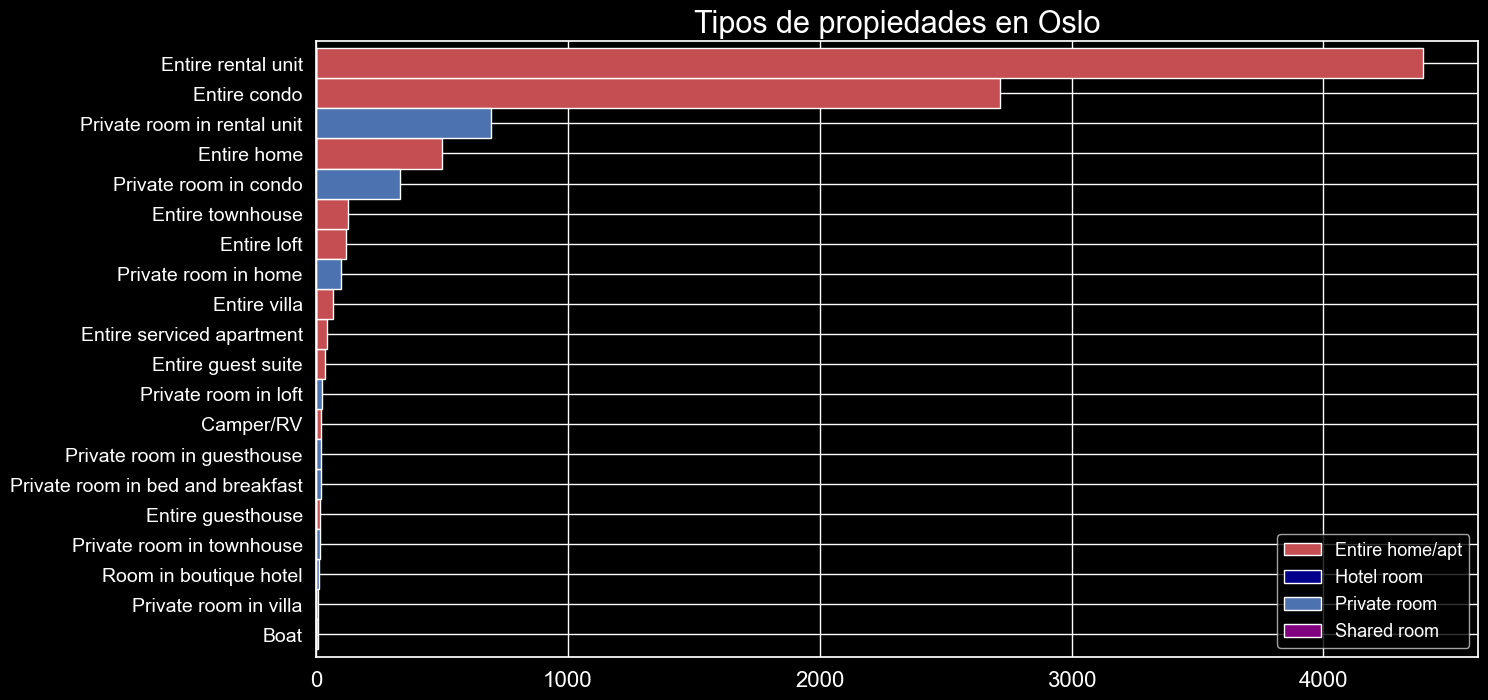

In [54]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=10]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","darkblue","b", "purple"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.style.use('dark_background')
plt.title('Tipos de propiedades en Oslo', fontsize=22)
plt.xlabel('')
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=14)
plt.show()

### 3.3 Número de alojados

Como suele ser normal en sitios turisticos como las grandes capitales, lo más demandado en cuanto al número de huéspedes es 2 personas, así como la familia tradicional compuesta por 4 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio. Estos datos, los refleja el gráfico que tenemos a continuación. 

In [23]:
feq=listings['accommodates'].value_counts().sort_index()
fig = px.bar(feq,title= "Numero de huéspedes en Oslo",template= "plotly_dark",
        labels=dict(index="Accomodates",value="Listings"), width = 1000)
fig.update_traces(texttemplate='%{y}', textposition='outside', marker=dict(color=['blue', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']))
fig.update_layout(title_font_size=28, xaxis_title='', yaxis_title='', showlegend=False)

fig.show()

## 4. PRECIO MEDIO POR VECINDARIO

Para comparar "manzanas con manzanas" solo seleccionaremos el tipo de alojamiento más común, que es el alojamiento para **2 personas**. Como era de esperar, el alojamiento en el **centro de la ciudad es el más caro**. Todo ello queda reflejado en Euros, la moneda oficial de la unión europea, pero cabe destacar que la moneda oficial de Noruega es la **Corona Noruega**, que equivale a **11,83 monedas por Euro**.

In [24]:
tasa_cambio = 11.82

listings['price_eur'] = listings['price'] / tasa_cambio

In [25]:
precio = listings.groupby('neighbourhood')['price_eur'].mean().sort_values(ascending = True).round(2)
dfprecio = pd.DataFrame(precio)
dfprecio = dfprecio.reset_index()

custom_colorscale = ["blue", "red"]
fig = px.bar(dfprecio, x="neighbourhood", y="price_eur", template="plotly_dark",
             title="Precio medio diario según el barrio en Oslo")
fig.update_traces(texttemplate='%{y}', textposition='outside', marker=dict(color=dfprecio['price_eur'], colorbar=dict(x=0.5, len=0.4),
                               colorscale=custom_colorscale, showscale=False,))
fig.update_layout(title_font_size=28, xaxis_title='', yaxis_title='')

fig.show()

In [26]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price_eur'].mean().sort_values(ascending=True)

In [27]:
adam = gpd.read_file("input/neighbourhoods.geojson")

feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price_eur': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=2)

map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['lightblue','blue','purple','red','darkred'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    if value is not None:
        return color_scale(value)
    else:
        return 'grey' 

In [28]:
map3 = folium.Map(location=[59.913333, 10.738889], zoom_start=10)

legend_colors = ['lightblue', 'blue', 'purple', 'red', 'darkred']  # Colores utilizados en la escala
legend_labels = ['Low', 'Medium', 'High']  # Etiquetas correspondientes

# Define una función para agregar la leyenda de colores
def add_color_legend(map_obj, colormap, labels):
    colormap.caption = ''
    colormap.add_to(map_obj)
    for label in labels:
        colormap.add_to(map_obj)

folium.GeoJson(data=adam,
               name='Oslo',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1.2,
                   'dashArray': '5, 5',
                   'fillOpacity': 1
               },
               highlight_function=lambda feature: {'weight': 2, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)

color_scale = LinearColormap(legend_colors, vmin=min(map_dict.values()), vmax=max(map_dict.values()))
color_scale.width = 450  # Ajusta el ancho
color_scale.height = 60  # Ajusta el alto

add_color_legend(map3, color_scale, legend_labels)
map3


También cabe destacar que cuanto más al este de Europa, más barato sale el alojamiento, si bien es verdad, que te alejas del centro de Oslo, también sucede esta lejania tanto por el norte como por el sur, pero el precio no desciende tanto, esto suele deberse al tipo de turismo rural, ya que sobre todo en la zona norte, se visitan muchos fenómenos naturales turísticos.

## 5. SEGURIDAD EN LOS VECINDARIOS

![Imagen indice](Indice_seguridad.png)
![Imagen seguridad](Datos_seguridad.png)

Fuente: https://es.numbeo.com/criminalidad/ciudad/Oslo
- https://www.travelsafe-abroad.com/es/noruega/oslo/

## 6. ANÁLISIS DE LAS REVIEWS (limpieza, precisión, valor, comunicación, ubicación, etc).

En esta sección, agrupamos los puntajes de revisión de la ubicación por vecindario (solo listados con al menos 10 revisiones). Aunque esperamos que la distancia al centro de la ciudad sea un factor importante, esta puntuación también debería tener en cuenta otras cosas. Otros factores pueden incluir:

* La seguridad de una ubicación (como se muestra en la sección anterior)
* Ruido. Si una lista tiene una ubicación central, pero está rodeada de bares ruidosos, eso debería costar puntos en el puntaje de revisión de la ubicación.
* Si un listado está ubicado fuera del centro de la ciudad pero bien conectado por transporte público, debería obtener puntos de bonificación por eso.
* Instalaciones cercanas al listado. ¿Hay supermercados, bares y restaurantes cerca?
* Lugares rurales turísticos.

Cabe destacar el buen promedio que tiene cada vecindario, superando todos el **4,5 sobre 5** que es la puntuación máxima. Asimismo, tenemos una **media de 4,8** en la puntuación.

Como consejo a los turístas, decirles que lo más conveniente sería alejarse un poco de los vecinandarios centricos y **desplazarse más al Este**, a vencindarios como **Alna, Stovner o Grorud**, donde el precio medio por día es muy bajo en comparación con el resto y aún así la puntuación no está nada mal. Si que es verdad que son los más alejados pero el transporte público es muy bueno y no hay una distancia muy grande al centro de Oslo.

In [29]:
print(listings['review_scores_location'].max())
print(listings['review_scores_location'].mean())

5.0
4.817103211312277


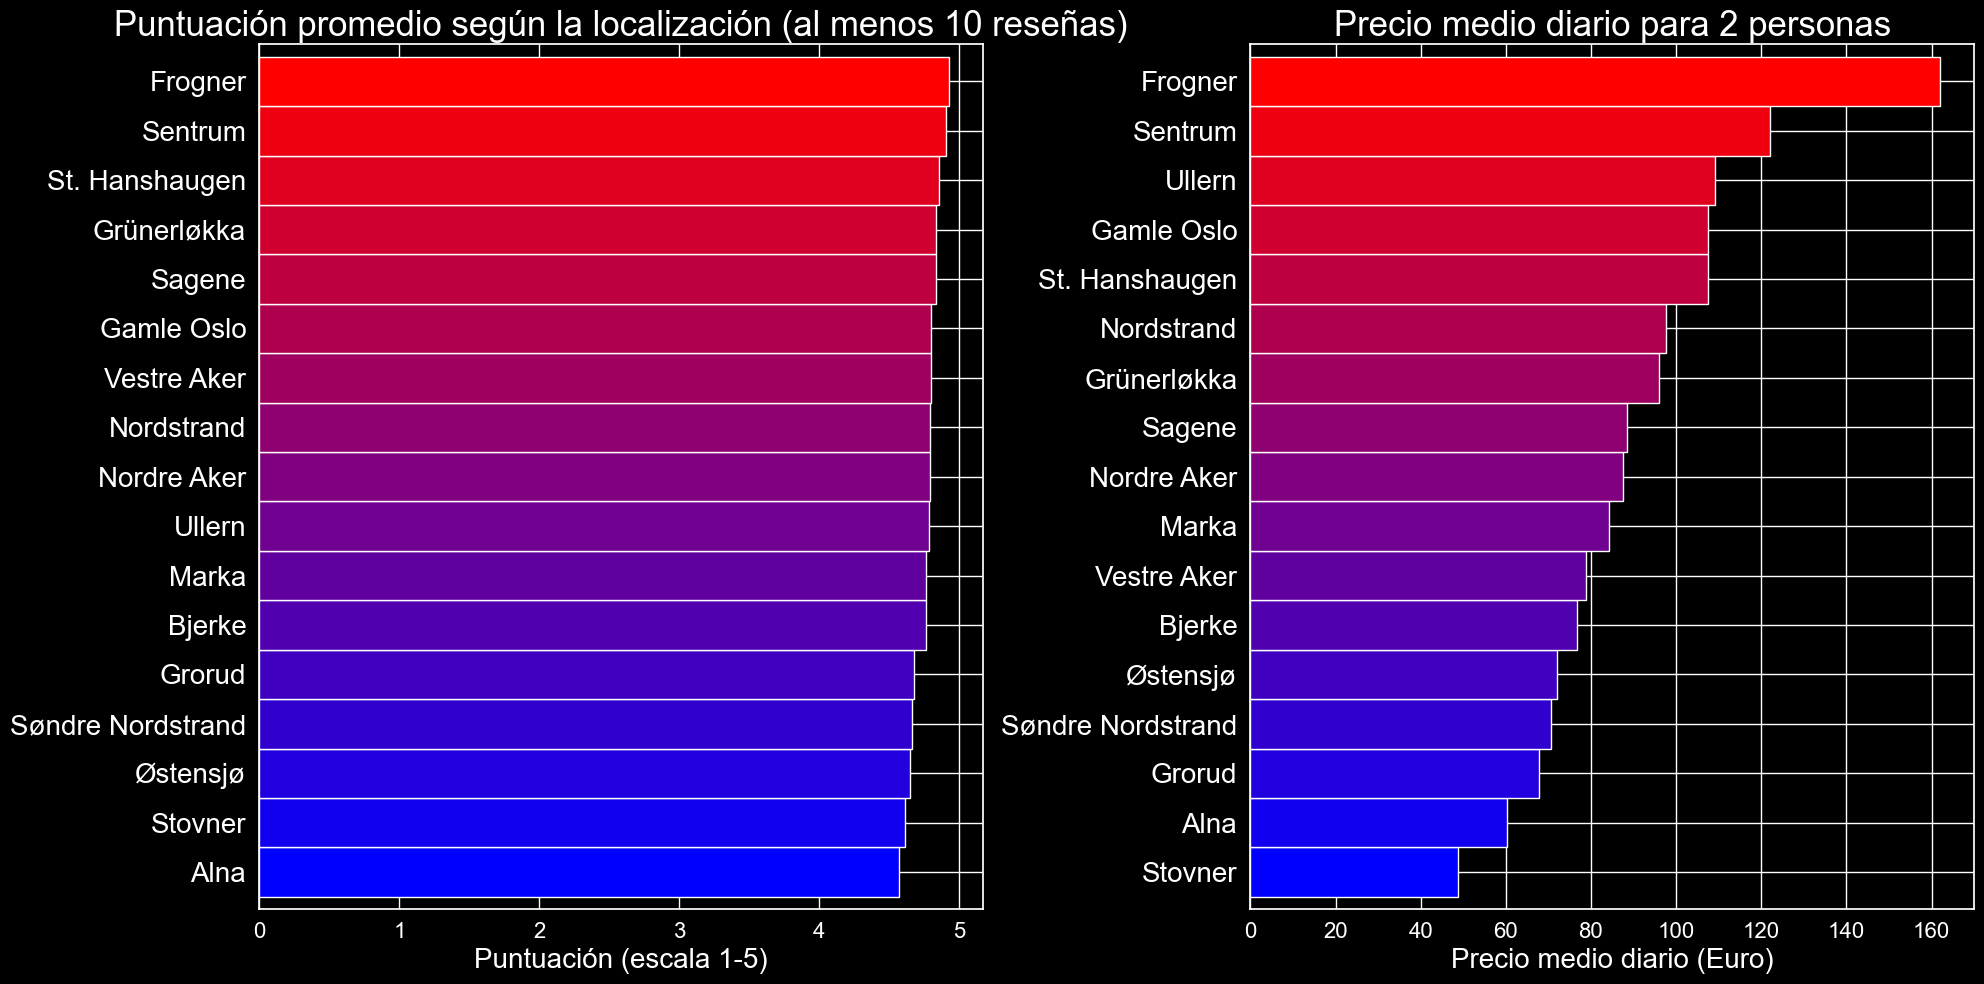

In [30]:
import matplotlib.colors as mcolors

start_color = "blue"
end_color = "red"

plt.style.use('dark_background')
fig = plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews'] >= 5]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
num_colors1 = len(feq1)
color_scale1 = mcolors.LinearSegmentedColormap.from_list("custom_colorscale1", [start_color, end_color], N=num_colors1)
colors1 = [color_scale1(i / (num_colors1 - 1)) for i in range(num_colors1)]
ax1 = feq1.plot.barh(color=colors1, width=1)
plt.title("Puntuación promedio según la localización (al menos 10 reseñas)", fontsize=25)
plt.xlabel('Puntuación (escala 1-5)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates'] == 2]
feq2 = feq.groupby('neighbourhood')['price_eur'].mean().sort_values(ascending=True)
num_colors2 = len(feq2)
color_scale2 = mcolors.LinearSegmentedColormap.from_list("custom_colorscale2", [start_color, end_color], N=num_colors2)
colors2 = [color_scale2(i / (num_colors2 - 1)) for i in range(num_colors2)]
ax2 = feq2.plot.barh(color=colors2, width=1)
plt.title("Precio medio diario para 2 personas", fontsize=25)
plt.xlabel('Precio medio diario (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()


In [31]:
# Redondeamos a 1 decimal
listings['review_scores_location'] = listings['review_scores_location'].round(1)
listings['review_scores_cleanliness'] = listings['review_scores_cleanliness'].round(1)
listings['review_scores_value'] = listings['review_scores_value'].round(1)
listings['review_scores_communication'] = listings['review_scores_communication'].round(1)
listings['review_scores_checkin'] = listings['review_scores_checkin'].round(1)
listings['review_scores_accuracy'] = listings['review_scores_accuracy'].round(1)

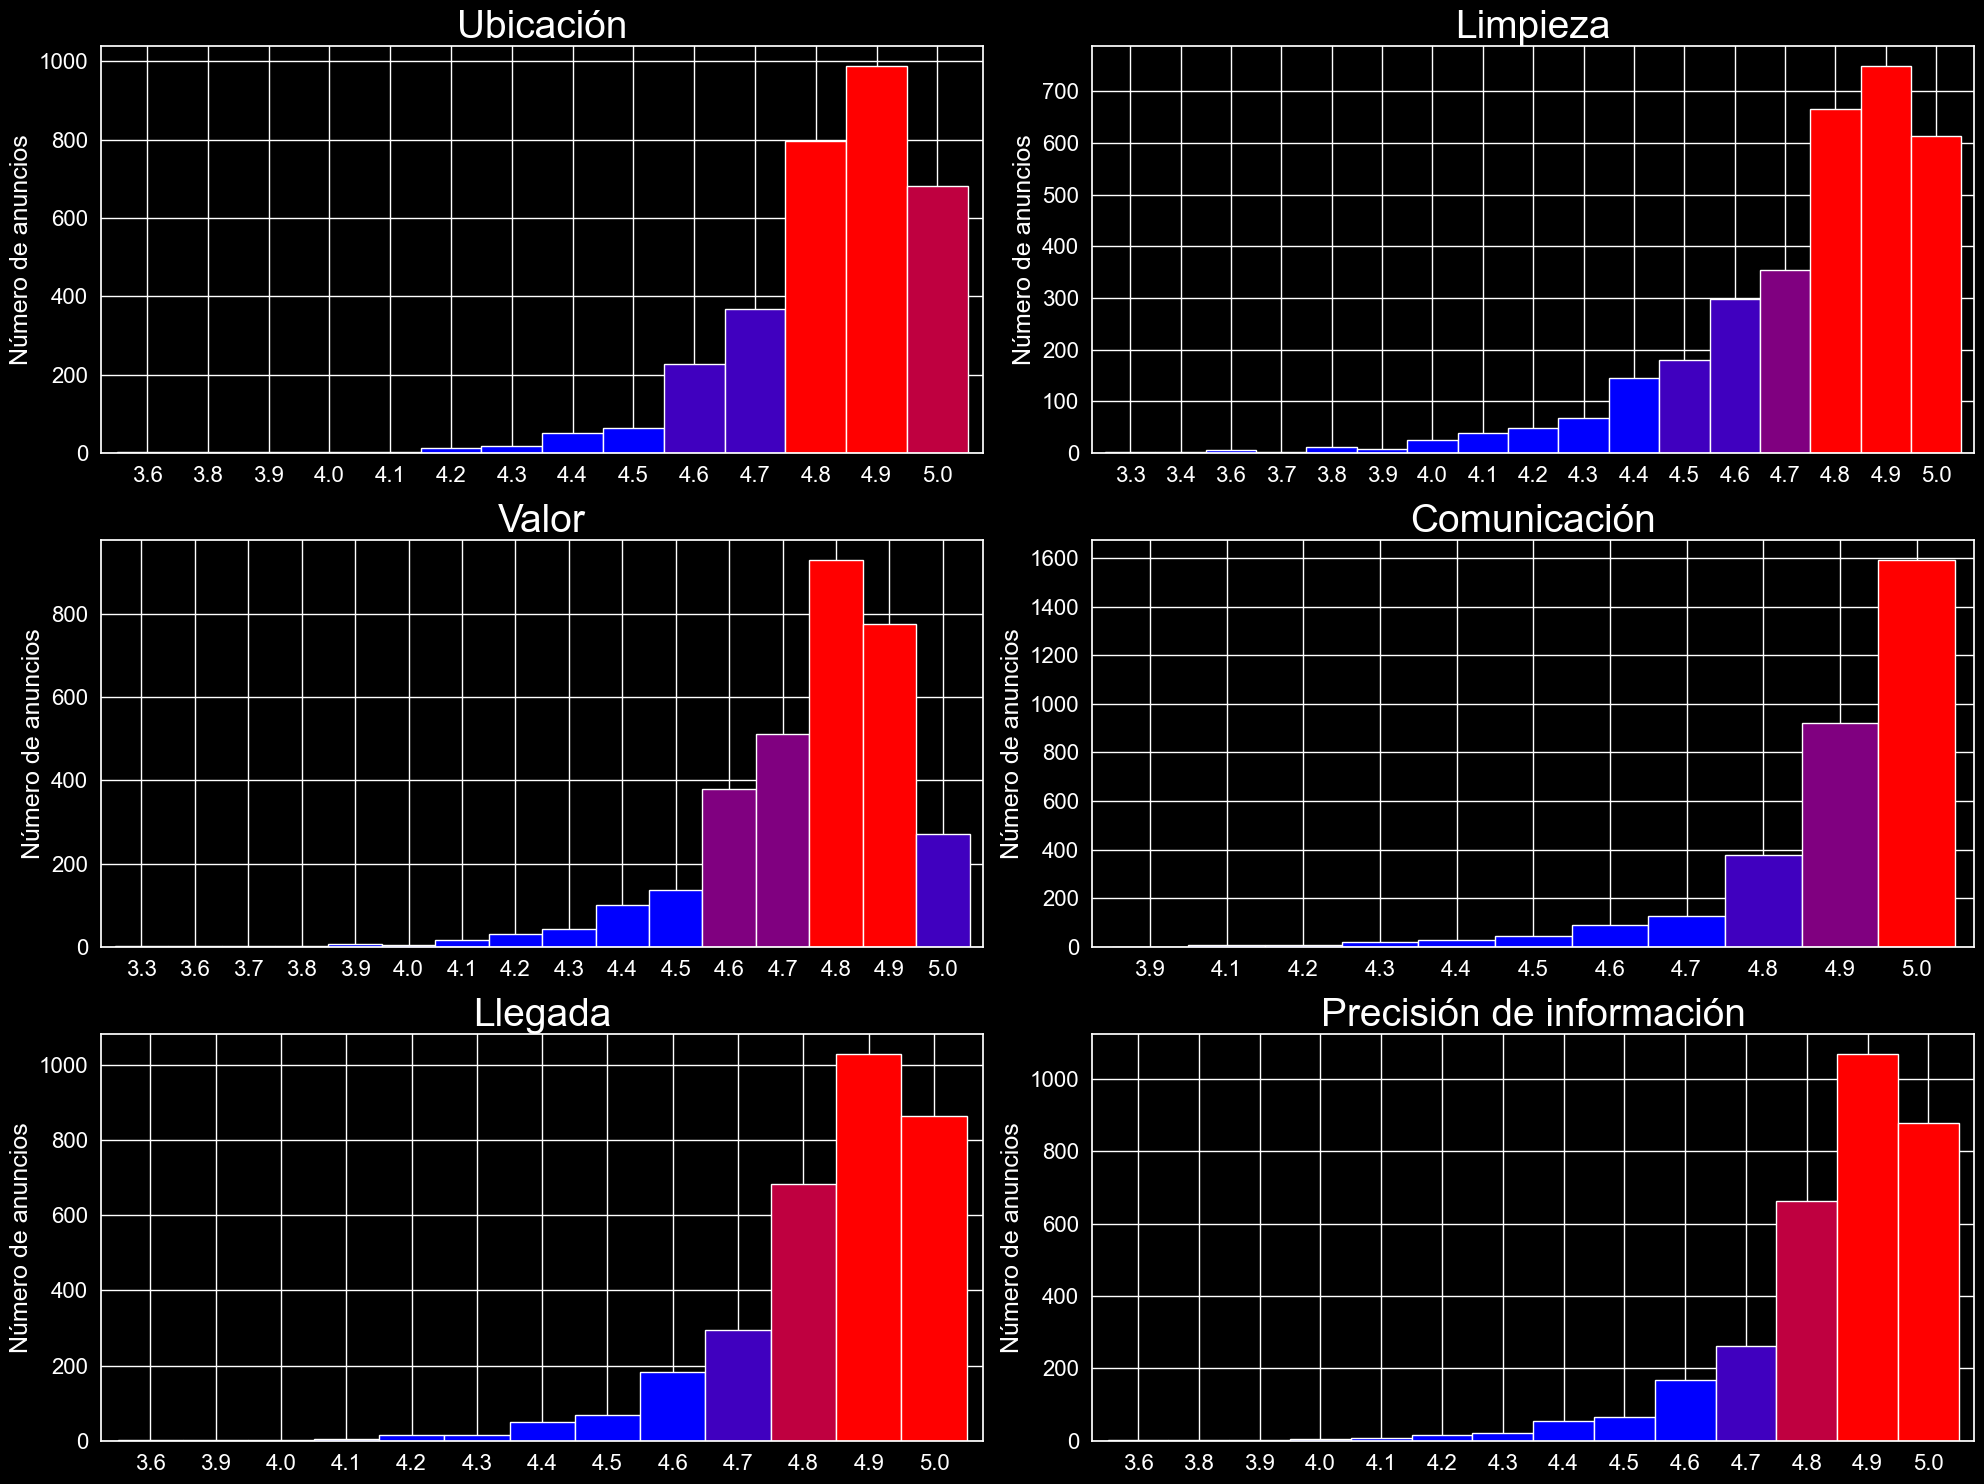

In [32]:
import matplotlib.colors as mcolors

start_color = "blue"
end_color = "red"
num_colors = 5

color_scale = mcolors.LinearSegmentedColormap.from_list("custom_colorscale", [start_color, end_color], N=num_colors)
plt.style.use('dark_background')
fig = plt.figure(figsize=(20, 15))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
listings10 = listings[listings['number_of_reviews']>=10]

def create_bar_plot(ax, feq, title, ylabel, xlabel):
    min_val = feq.min()
    max_val = feq.max()
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    colors = [color_scale(norm(val)) for val in feq]
    ax = feq.plot.bar(color=colors, width=1, rot=0)
    ax.tick_params(axis='both', labelsize=16)
    plt.title(title, fontsize=28)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlabel(xlabel, fontsize=18)

# Gráfico 1
ax1 = fig.add_subplot(321)
feq = listings10['review_scores_location'].value_counts().sort_index()
create_bar_plot(ax1, feq, "Ubicación", 'Número de anuncios', '')

# Gráfico 2
ax2 = fig.add_subplot(322)
feq = listings10['review_scores_cleanliness'].value_counts().sort_index()
create_bar_plot(ax2, feq, "Limpieza", 'Número de anuncios', '')

# Gráfico 3
ax3 = fig.add_subplot(323)
feq = listings10['review_scores_value'].value_counts().sort_index()
create_bar_plot(ax3, feq, "Valor", 'Número de anuncios', '')

# Gráfico 4
ax4 = fig.add_subplot(324)
feq = listings10['review_scores_communication'].value_counts().sort_index()
create_bar_plot(ax4, feq, "Comunicación", 'Número de anuncios', '')

# Gráfico 5
ax5 = fig.add_subplot(325)
feq = listings10['review_scores_checkin'].value_counts().sort_index()
create_bar_plot(ax5, feq, "Llegada", 'Número de anuncios', '')

# Gráfico 6
ax6 = fig.add_subplot(326)
feq = listings10['review_scores_accuracy'].value_counts().sort_index()
create_bar_plot(ax6, feq, "Precisión de información", 'Número de anuncios', '')

plt.tight_layout()
plt.show()

Como hemos visto en estos gráficos sobre las puntuaciones que ha dado la gente en las diferentes categorías que deja la plataforma Airbnb, en su gran mayoría **superan el 4 sobre 5**, por lo que podemos recomendar que estando entre esos baremos, cualquier hospedaje es bueno, eso sí, en la categoría de **limpieza todo lo que baje del 4 no lo recomendaría**. A destacar también el **alto puntaje en la categoría de comunicación**, que como hemos dicho anteriormente, tanto el **transporte público como las carreteras son de muy buena calidad**.

## 7. SUPERHOST

El SuperHost es una figura única en la plataforma y muy dificil de conseguir. Para ello hay que conseguir una serie de requisitos que te marca Airbnb:    

**Cada 3 meses, se verifica** si se cumple con los siguientes criterios. Si se consigue, se gana o se mantiene el estatus.
- Tener una calificación general promedio de 4.8 o superior según las reseñas de al menos el 50 % de sus huéspedes de Airbnb durante el último año.   
- Haber alojado al menos 10 estadías en el último año o, si realizan reservas a más largo plazo, 100 noches en al menos 3 estadías.   
- No tener cancelaciones en el último año, a menos que haya circunstancias atenuantes.      
- Responden al 90 % de los mensajes nuevos en 24 horas.

Como veremos a continuación, **encontrarnos con un SuperHost es muy complicado** ya que hay muy pocos que logren cumplir estos requisitos.

### 7.1 Número y porcentaje de anuncios con Superhost

In [33]:
listings['host_is_superhost'] = listings['host_is_superhost'].replace({"t": "True", "f": "False"})
feq = listings['host_is_superhost'].value_counts().reset_index()
feq.columns = ['host_is_superhost', 'Number of listings']
colors = ['red', 'blue']

fig = px.bar(feq, x='host_is_superhost', y='Number of listings', color='host_is_superhost', color_discrete_sequence=colors,
             title="Número de anuncios con Superhost", template= "plotly_dark")
fig.update_xaxes(categoryorder="total ascending")
fig.update_layout(width=800, height=600)
fig.update_layout(title_font_size=28, xaxis_title='', yaxis_title='')
fig.update_traces(showlegend=False)

fig.show()

In [34]:
feq = listings['host_is_superhost'].value_counts().reset_index()
feq.columns = ['names', 'values']
colores = ['red', 'blue']

fig = px.pie(feq, names='names', values='values', width=1000, template="plotly_dark",
              title="Porcentaje de anuncios con Superhost",color_discrete_sequence=colores)
fig.update_layout(width=800, height=600)
fig.update_layout(title_font_size=28, xaxis_title='', yaxis_title='')

fig.show()

Como hemos visto **solamente 1 de cada 7 hospedadores**, consigue la categoría de SuperHost. De cara a los turístas, sabemos que va a ser complicado encontrar una persona como estas como hospedador, con lo que conlleva también economicamente, ya que seguramente las personas con esta categoría **aumentarán sus precios**. Pero en la medida de lo posible, intentad dar con ella ya que la seguridad que conlleva es muy grande de cara a hacer un viaje a Oslo.

### 7.2 Tiempo de respuesta

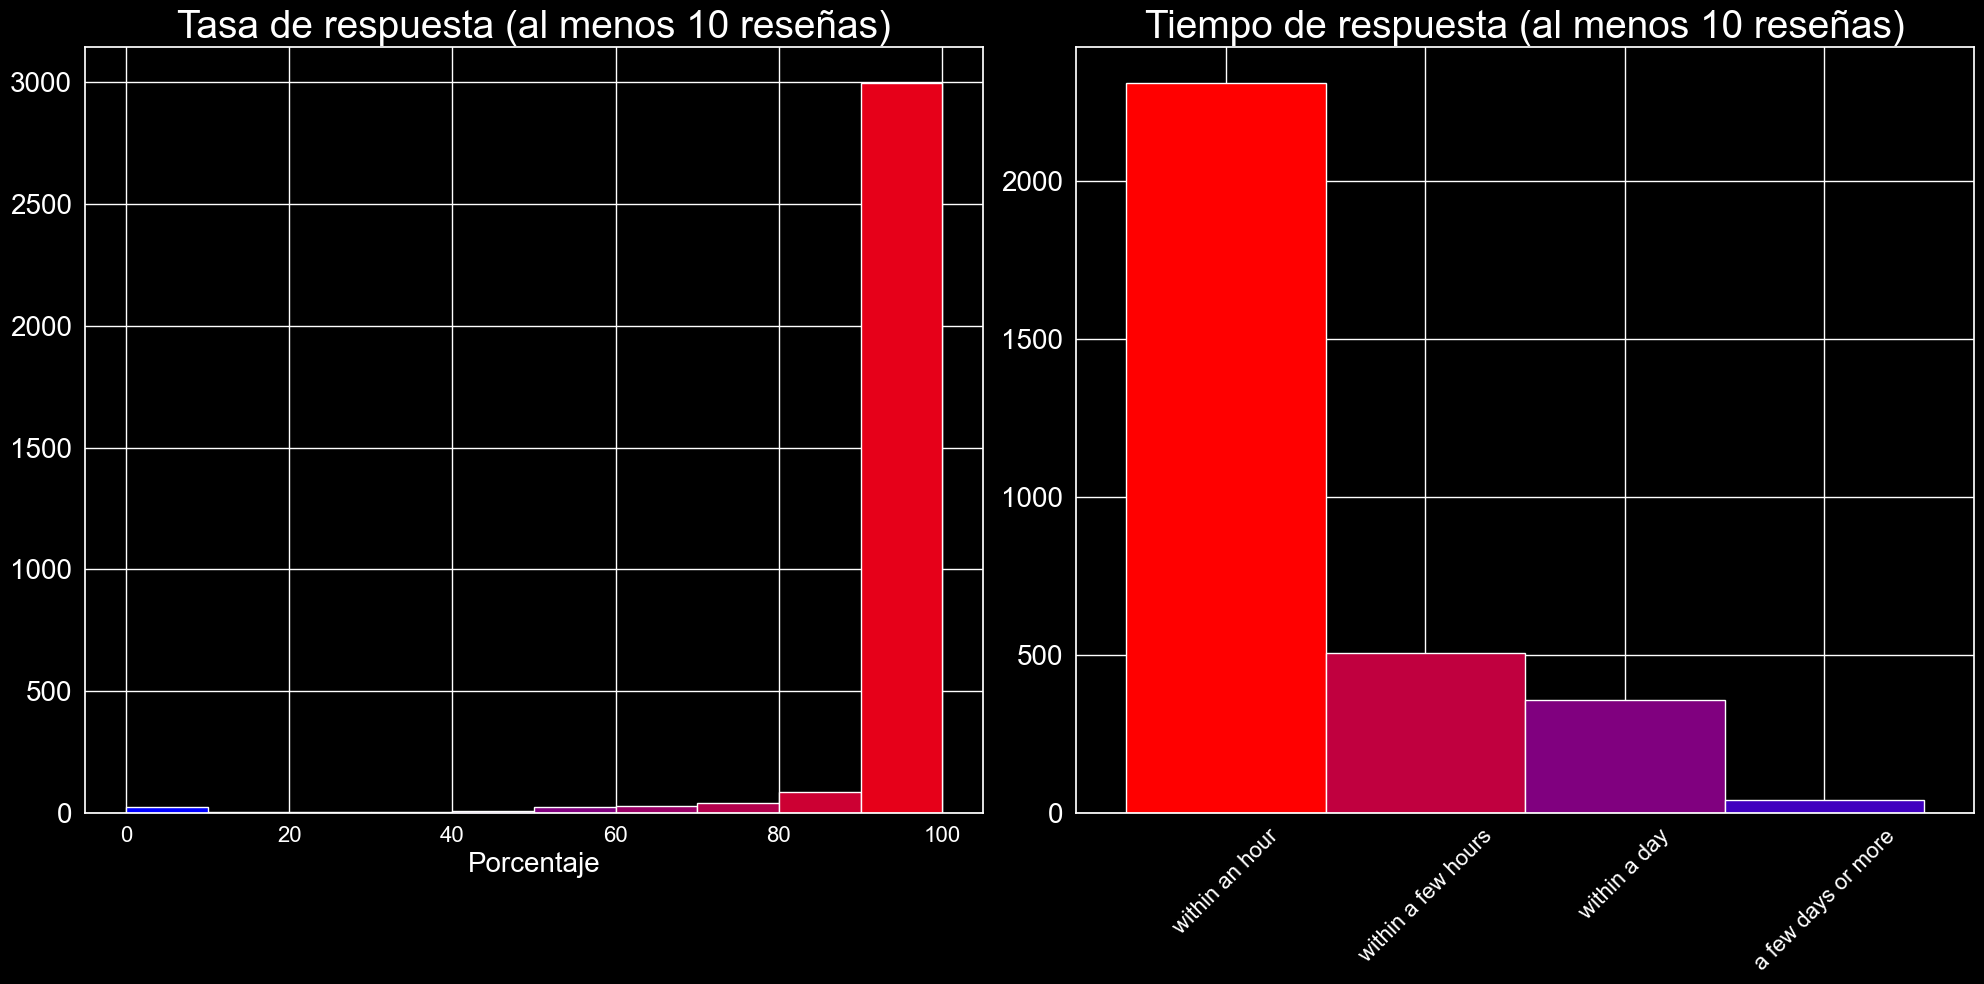

In [35]:
# Crear tu propia paleta de colores
custom_cmap = mcolors.LinearSegmentedColormap.from_list("BlueRed", ["blue", "red"])

plt.style.use('dark_background')
fig = plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
n, bins, patches = ax1.hist(feq1, color='red', bins=10)  # Color inicial en rojo

# Asignar la paleta de colores personalizada al primer gráfico
for patch in patches:
    patch.set_facecolor(custom_cmap(patch.get_x() / bins.max()))

plt.title("Tasa de respuesta (al menos 10 reseñas)", fontsize=28)
plt.ylabel("")
plt.xlabel("Porcentaje", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()

# Asignar la paleta de colores personalizada al segundo gráfico en orden invertido
colors2 = [custom_cmap(1 - x / len(feq2)) for x in range(len(feq2))]
feq2.plot.bar(color=colors2, width=1, rot=45)
plt.title("Tiempo de respuesta (al menos 10 reseñas)", fontsize=28)
plt.ylabel("")
plt.xlabel("")

plt.tight_layout()
plt.show()

In [36]:
listings.head(5)

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_response_time,host_response_rate,price_eur
id,,,,,,,,,,,,,,,,,,,,,
914274430810474746,Rental unit in Bydel Alna · ★5.0 · 2 bedrooms ...,34923127,Leif,Alna,59.936718,10.925452,Entire home/apt,750,3,4,...,4.8,5.0,4.8,5.00,31,https://www.airbnb.com/rooms/914274430810474746,False,within an hour,100.000000,63.451777
42932,Rental unit in Oslo · ★4.90 · 2 bedrooms · 3 b...,187463,Cecilie,Frogner,59.912010,10.724550,Entire home/apt,3400,3,56,...,5.0,5.0,4.9,4.90,1125,https://www.airbnb.com/rooms/42932,True,within an hour,100.000000,287.648054
69964,Rental unit in Oslo · ★4.78 · 1 bedroom · 1 be...,175633,Kristin,Sagene,59.940590,10.773970,Entire home/apt,1098,28,9,...,4.8,5.0,5.0,4.78,600,https://www.airbnb.com/rooms/69964,False,within an hour,92.673406,92.893401
71725,Rental unit in Oslo · ★4.74 · 1 bedroom · 2 be...,368229,Reidun,Gamle Oslo,59.907950,10.779870,Private room,573,14,55,...,4.7,4.9,5.0,4.74,730,https://www.airbnb.com/rooms/71725,True,within an hour,92.673406,48.477157
85902,Condo in Oslo · ★4.77 · 2 bedrooms · 3 beds · ...,250159,Melissa,Gamle Oslo,59.910740,10.772320,Entire home/apt,1300,3,77,...,4.8,4.8,4.7,4.77,21,https://www.airbnb.com/rooms/85902,True,within an hour,100.000000,109.983080


### 7.3 Host con más alojamientos

Vamos a analizar cual es el host con más alojamientos en Oslo y ver donde los tiene ubicados para ver si podemos sacar alguna conclusión interesante de los datos resultantes.

In [37]:
private = listings[listings['room_type'] == "Entire home/apt"]
host_max = private.groupby(['host_id', 'host_name', 'neighbourhood']).size().reset_index(name='Entire home/apt').sort_values(by=['Entire home/apt'], ascending=False)
host_max.head(10)

,host_id,host_name,neighbourhood,Entire home/apt
5870,233933220,Urban,St. Hanshaugen,41
5869,233933220,Urban,Grünerløkka,34
3222,58865973,Kevin,Gamle Oslo,15
1425,20437055,Mauri,Gamle Oslo,13
1753,25927831,Haakon,Grünerløkka,11
4324,98022652,Akers Have,Gamle Oslo,9
7213,488587310,Bjørvika,Gamle Oslo,8
7261,496524596,Numa Topp,Frogner,8
3304,61362055,Jarle M.,Frogner,6
5172,153268748,Martin,Frogner,6


In [38]:
Urban = private[private['host_id']== 233933220]
Urban = Urban[['name','host_id', 'host_name', 'latitude', 'longitude']]
Urban.index.name = "listing_id"
Urban

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
31263541,Loft in Grünerløkka · ★4.52 · Studio · 1 bed ·...,233933220,Urban,59.92302,10.76010
31820064,Rental unit in Grünerløkka · ★4.54 · 1 bedroom...,233933220,Urban,59.92421,10.75991
31968405,Rental unit in Grünerløkka · ★4.71 · 2 bedroom...,233933220,Urban,59.92335,10.76169
31968840,Rental unit in Grünerløkka · ★4.49 · 2 bedroom...,233933220,Urban,59.92299,10.75991
32152496,Rental unit in Grünerløkka · ★4.51 · Studio · ...,233933220,Urban,59.92286,10.75993
...,...,...,...,...,...
674484048101620338,Condo in Sankt Hanshaugen · ★4.42 · 1 bedroom ...,233933220,Urban,59.92061,10.74328
699726251106281613,Rental unit in Sankt Hanshaugen · ★4.37 · Stud...,233933220,Urban,59.92040,10.74105
700361514690372570,Condo in Grünerløkka · ★4.59 · 1 bedroom · 1 bath,233933220,Urban,59.92281,10.76035


In [39]:
#Vemos en un mapa las propiedades de Urban
map2 = folium.Map(location=[59.913333, 10.738889], zoom_start=13)
for coord in Urban.itertuples(index=False):
    folium.Marker((coord.latitude, coord.longitude), tooltip=coord.name).add_to(map2)
map2

Como vemos en el mapa, el **host Urban** tiene localizados todos su alojamientos en 2 barrios, el de **Grünerløkka y St. Hanshaugen**, viendo un poco las puntuaciones, rondan entre el **4,4 y el 4,8** por lo que puede ser un host recomendable, además son dos barrios que están en el **top 4 en la escala de localización** y no están tan arriba en el precio medio por día.

## 8. DISPONIBILIDAD EN EL TIEMPO

Otro de los aspectos más importantes a tener en cuenta es la gestión del tiempo a la hora de reservar un alojamiento. A continuación vamos a hacer un desglose del mismo y ver también **qué época del año sale mejor económicamente**.

### 8.1 Publicaciones disponibles por fecha

In [40]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

,date,available,price,adjusted_price,minimum_nights,maximum_nights,accommodates
listing_id,,,,,,,
35541165,2023-10-06,f,"$1,100.00","$1,100.00",4,31,2
51550997,2024-07-13,f,"$2,650.00","$2,650.00",2,14,6
909852391840837913,2023-10-08,f,"$1,150.00","$1,150.00",3,365,5
899053605864531696,2023-11-30,t,$800.00,$800.00,4,20,1
19362385,2024-01-02,f,$682.00,$682.00,1,90,4
754155495883413610,2024-06-09,t,"$1,099.00","$1,099.00",5,365,2
827654355446135225,2024-07-14,t,"$2,500.00","$2,500.00",5,1125,5
36502626,2023-10-07,f,"$2,500.00","$2,500.00",4,10,10
32157238,2024-06-23,t,"$1,350.00","$1,350.00",2,1125,2


In [41]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sum_available.index, y=sum_available['available'], mode='lines', line=dict(color='red'), text=sum_available['weekday']))
fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    title='Número de publicaciones disponibles por fecha',
    paper_bgcolor='black',
    plot_bgcolor='black', 
    font=dict(color='blue'),
    title_font=dict(size=30, color='white'),
    xaxis=dict(tickfont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16)
))

fig.show()


Como vemos en el gráfico cada **3 meses hay un bajón importante** en cuanto al número de anuncios de alojamientos. Esto será debido seguramente a que los hospedadores actualicen automaticamente sus publicaciones en ese periodo de tiempo. Aún así la cifra de hospedaje disponible **no baja de 2.000** en ningún momento, por lo que se cuenta con una importante variedad de alojamiento hasta un año vista.

### 8.2 Precio medio por día

In [43]:
calendar['price'] = calendar['price'].str.replace('$', '').str.replace(',', '').astype(float)

In [44]:
tasa_cambio2 = 1.07

calendar['price_eur'] = calendar['price']/ tasa_cambio2

In [45]:
from plotly.subplots import make_subplots

filtered_calendar = calendar[(calendar['available'] == 't') & (calendar['accommodates'] == 2)]

average_price = filtered_calendar.groupby('date')['price_eur'].mean().reset_index()

average_price['date'] = pd.to_datetime(average_price['date'])
average_price['weekday'] = average_price['date'].dt.day_name()

# Crear un gráfico de líneas con Plotly
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=average_price['date'], y=average_price['price_eur'], mode='lines', line=dict(color='red'), text=average_price['weekday']))
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')
fig.update_layout(title_text='Precio promedio de alojamiento disponible para 2 personas por fecha', paper_bgcolor='black',
    plot_bgcolor='black', font=dict(color='blue'),
    title_font=dict(size=30, color='white'),
    xaxis=dict(tickfont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16)))

fig.show()

En este gráfico se ve reflejado las mejores épocas en las que alojarse de manera económica. De todas maneras puede ser que los precios que vemos no sean los reales y esto puede ocasionar que los **anfitriones cancelen reservas si ven que son muy anticipadas, para no perder dinero**. Como consejo a los turistas, que prueben a reservar con meses de antelación, siempre asegurandose de que no se pierde el dinero en caso de que se cancele, y si el hospedador, cancela la reserva, tener un plan B asegurado y si no cancela, se habrán ahorrado mucho dinero ya que como se ve en el gráfico **sale a cuenta reservar con antelación**.

En cuanto a las fechas más caras, aparece el 30 de diciembre y el 29 de junio, ambas caen en sábado, la primera debida al fin de año y la segunda probablemente al incio de las vacaciones de verano.

## 9. MINERIA DE TEXTO DE LAS REVIEWS

EXPLICACIÓN DE ESTE APARTADO

In [46]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
5030998,613873,Loft in Oslo · ★4.88 · 1 bedroom · 1 bed · 1 bath,1272535,Elin Killie,2013-06-08,2798,Ayeh,"Elin's loft is warm, superbly comfortable and ..."
934667797355560195,914274430810474746,Rental unit in Bydel Alna · ★5.0 · 2 bedrooms ...,34923127,Leif,2023-07-13,231954938,Ali Hasan,Fin leilighet med flott beliggenhet mellom Osl...
951309386140201025,914274430810474746,Rental unit in Bydel Alna · ★5.0 · 2 bedrooms ...,34923127,Leif,2023-08-05,266060660,Kasper,Super majutaja. Väga sõbralik ja jagas palju i...
955610965430276739,914274430810474746,Rental unit in Bydel Alna · ★5.0 · 2 bedrooms ...,34923127,Leif,2023-08-11,39473429,Ingvill Førde,Særs positiv oppleving. <br/>Ikkje noko negati...
960704545012498083,914274430810474746,Rental unit in Bydel Alna · ★5.0 · 2 bedrooms ...,34923127,Leif,2023-08-18,174059071,Jakub,"Apartment was very clean and spacious, there w..."


In [47]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

,,number_of_reviews
host_id,host_name,
233933220,Urban,5267
81048880,Anders,1950
4011871,Mona Johanne,1082
8079685,Kim & Jen,968
7121844,Line K.,894


In [48]:
reviews_details.comments.head()

id
5030998               Elin's loft is warm, superbly comfortable and ...
934667797355560195    Fin leilighet med flott beliggenhet mellom Osl...
951309386140201025    Super majutaja. Väga sõbralik ja jagas palju i...
955610965430276739    Særs positiv oppleving. <br/>Ikkje noko negati...
960704545012498083    Apartment was very clean and spacious, there w...
Name: comments, dtype: object

In [49]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
#remove stopwords (from nltk library)
stop_norwegian = stopwords.words("norwegian")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_norwegian)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

'super majutaja. väga sõbralik jagas palju infot ümbruskonna kohta.'

In [51]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
88,br,63396
41,apartment,52556
8,great,52368
10,oslo,50691
139,place,47060
166,stay,46525
116,nice,35009
144,location,34027
33,host,30237
106,clean,27624


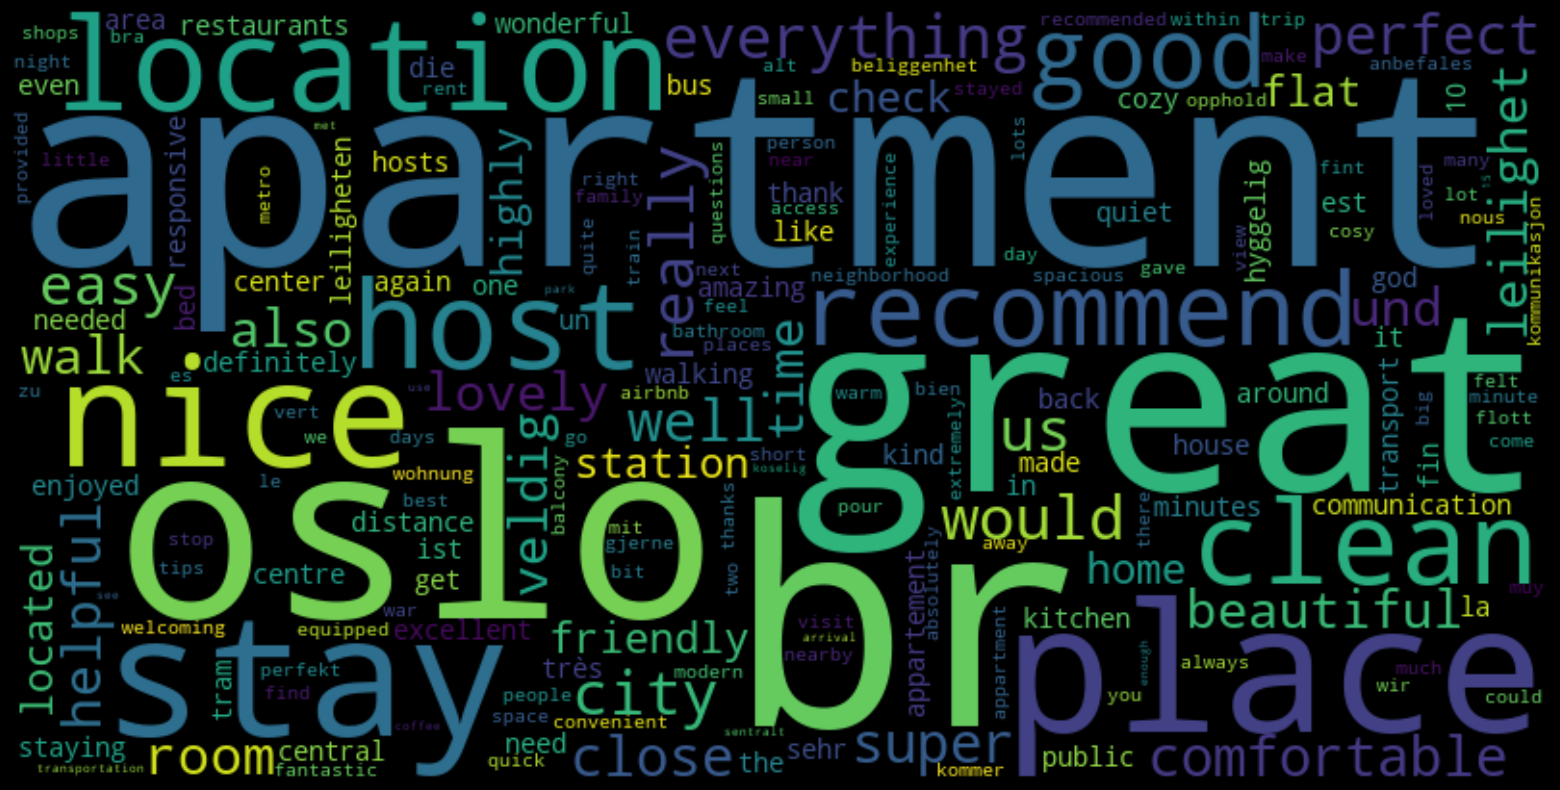

In [52]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 10. CONCLUSIONES

En resumen, Oslo ofrece una amplia gama de opciones de alojamiento en diversos vecindarios, con **altos estándares de calidad y seguridad**.
   - Los turistas pueden seleccionar alojamientos que se ajusten a su presupuesto y preferencias gracias a la diversidad de opciones, siendo **las casas y apartamentos completos** como la más seleccionada.
   
   - Los **17 barrios tienen una puntuación por encima del 4,5 sobre 5** en todas las cateogrías disponibles, aun así es recomendable hospedarse en el Este donde el precio medio desciende con respecto al centro de la provincia y la **comunicación es buena igualmente**.

   - Los superhosts y las excelentes reseñas garantizan una experiencia de hospedaje excepcional, **todas por encima del 4 sobre 5** en el nivel de puntuación.
   
   - La disponibilidad y los precios varían según la temporada, lo que puede influir en la planificación del viaje, siendo **recomendable coger con anticipación las fechas**, ya que sale más económico, alrededor de 300€ o 400€ menos.

En general, Oslo se presenta como un destino atractivo para los turistas con una oferta variada y de calidad en términos de alojamiento. La combinación de precios competitivos, seguridad y una amplia gama de opciones hace que Oslo sea una elección atractiva para una **pareja de turistas en busca de una experiencia memorable**.
